In [2]:
import torch, torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# transform the image dataset to PyTorch tensors and Normalize it using mean and std.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# download dataset
train_ds = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

60000 10000


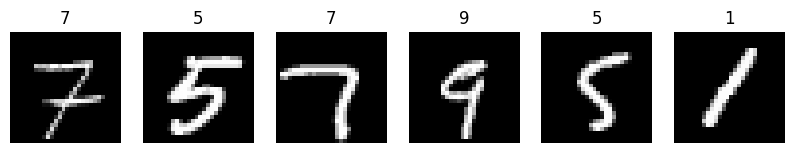

In [4]:
print(len(train_ds), len(test_ds))   # 60000, 10000
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=1000, shuffle=False)

# visualize 6 images
examples = iter(train_loader)
images, labels = next(examples)
fig, axs = plt.subplots(1,6, figsize=(10,2))
for i in range(6):
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_title(int(labels[i].item()))
    axs[i].axis('off')
plt.show()

# Nueral network Architecture

In [4]:
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import random

# reproducibility(without this training might give slightly different results in each run)
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256) #fully connected
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x


In [6]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, correct/total

def eval_model(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return total_loss/total, correct/total

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [7]:
# training loop
epochs = 10
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = eval_model(test_loader)
    print(f"Epoch {epoch} | train_loss {train_loss:.4f} acc {train_acc:.4f}  | test_loss {val_loss:.4f} acc {val_acc:.4f}")

# save
torch.save(model.state_dict(), 'mlp_mnist.pth')

Epoch 1 | train_loss 0.2576 acc 0.9218  | test_loss 0.1112 acc 0.9639
Epoch 2 | train_loss 0.1177 acc 0.9641  | test_loss 0.1431 acc 0.9519
Epoch 3 | train_loss 0.0892 acc 0.9722  | test_loss 0.0889 acc 0.9727
Epoch 4 | train_loss 0.0728 acc 0.9767  | test_loss 0.0843 acc 0.9750
Epoch 5 | train_loss 0.0657 acc 0.9788  | test_loss 0.0738 acc 0.9769
Epoch 6 | train_loss 0.0559 acc 0.9818  | test_loss 0.0723 acc 0.9792
Epoch 7 | train_loss 0.0516 acc 0.9827  | test_loss 0.0710 acc 0.9786
Epoch 8 | train_loss 0.0470 acc 0.9845  | test_loss 0.0795 acc 0.9798
Epoch 9 | train_loss 0.0428 acc 0.9857  | test_loss 0.0672 acc 0.9823
Epoch 10 | train_loss 0.0413 acc 0.9862  | test_loss 0.0777 acc 0.9800


# Visualize Mistakes and confusions

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

# collect predictions on test set
model.eval()
ys, ypreds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        ypreds.extend(preds)
        ys.extend(yb.numpy())

print(classification_report(ys, ypreds))
cm = confusion_matrix(ys, ypreds)
print(cm)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 973    0    1    0    0    0    3    0    2    1]
 [   0 1119    2    2    0    1    1    1    9    0]
 [   4    1 1008    3    2    0    0    7    7    0]
 [   0    0    2  994    0    1    0    5    1    7]
 [   1    0    4    0  968   

In [13]:
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import random

# reproducibility(without this training might give slightly different results in each run)
torch.manual_seed(42); np.random.seed(42); random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # -> 28x28
        self.pool = nn.MaxPool2d(2, 2)                           # -> 14x14
        self.drop = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*14*14//4, 128)  # careful on sizes (we'll use a pooling twice or adapt)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# A simpler, well-behaved CNN:
class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),                 # 7x7
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 10)
        )
    def forward(self, x): return self.layers(x)

model = BetterCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()



Using: cpu


In [14]:
###################
epochs = 14
for epoch in range(epochs):
    model.train()
    train_loss, correct = 0, 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()

    print(f"Epoch {epoch+1}: "
          f"Train Loss={train_loss/len(train_loader):.4f}, "
          f"Accuracy={100. * correct/len(train_ds):.2f}%")
torch.save(model.state_dict(), "cnn_mnist.pth")


Epoch 1: Train Loss=0.1612, Accuracy=95.02%
Epoch 2: Train Loss=0.0531, Accuracy=98.38%
Epoch 3: Train Loss=0.0367, Accuracy=98.83%
Epoch 4: Train Loss=0.0289, Accuracy=99.08%
Epoch 5: Train Loss=0.0242, Accuracy=99.23%
Epoch 6: Train Loss=0.0192, Accuracy=99.37%
Epoch 7: Train Loss=0.0175, Accuracy=99.43%
Epoch 8: Train Loss=0.0143, Accuracy=99.55%
Epoch 9: Train Loss=0.0115, Accuracy=99.62%
Epoch 10: Train Loss=0.0120, Accuracy=99.57%
Epoch 11: Train Loss=0.0101, Accuracy=99.66%
Epoch 12: Train Loss=0.0085, Accuracy=99.73%
Epoch 13: Train Loss=0.0080, Accuracy=99.72%
Epoch 14: Train Loss=0.0081, Accuracy=99.73%
